In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
population_df = pd.read_csv('C:/Users/Hamid/Downloads/Global_Population.csv')
gdp_df = pd.read_csv('C:/Users/Hamid/Downloads/Global_GDP.csv')

In [3]:
population_df.head()

,Country Name,Country Code,Series Name,Series Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211,55438,56225,56695,57032,57360,...,102560,103159,103774,104341,104872,105366,105845,106314,NaN,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996967,9169406,9351442,9543200,9744772,9956318,...,31161378,32269592,33370804,34413603,35383028,36296111,37171922,38041757,38928341,39835000
2,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130836765,134159786,137614644,141202036,144920186,148769974,...,547482863,562601578,578075373,593871847,609978946,626392880,643090131,660046272,677243299,694664000
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,96396419,98407221,100506960,102691339,104953470,107289875,...,370243017,380437896,390882979,401586651,412551299,423769930,435229381,446911598,458803476,470898000
4,Albania,ALB,"Population, total",SP.POP.TOTL,1608800,1659800,1711319,1762621,1814135,1864791,...,2900401,2895092,2889104,2880703,2876101,2873457,2866376,2854191,2837743,2832000


In [4]:
gdp_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.549721e+09,2.534637e+09,2.727850e+09,2.790849e+09,2.962905e+09,2.983637e+09,3.092430e+09,3.202189e+09,NaN,NaN
1,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,1.929944e+10,1.970954e+10,2.147872e+10,2.571501e+10,2.351080e+10,2.679160e+10,...,9.427110e+11,9.498490e+11,9.635600e+11,9.837490e+11,9.186470e+11,8.720230e+11,9.842560e+11,1.011720e+12,1.008380e+12,9.188150e+11
2,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,1.780511e+10,1.990732e+10,2.014640e+10,2.049713e+10,1.913421e+10,1.811656e+10,1.875347e+10,1.805323e+10,1.879945e+10,2.011614e+10
3,Africa Western and Central,AFW,GDP (current US$),NY.GDP.MKTP.CD,1.040428e+10,1.112805e+10,1.194335e+10,1.267652e+10,1.383858e+10,1.486247e+10,...,6.709630e+11,7.275710e+11,8.207880e+11,8.514870e+11,7.607300e+11,6.905430e+11,6.837420e+11,7.416920e+11,7.945720e+11,7.845880e+11
4,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.117900e+11,1.280530e+11,1.367100e+11,1.457120e+11,1.161940e+11,1.011240e+11,1.221240e+11,1.013530e+11,8.941719e+10,5.837598e+10


In [5]:
# Identify the number of missing years for each country in the population dataset
population_missing_years = population_df.loc[:, '2001':'2020'].isna().sum(axis=1)
gdp_missing_years = gdp_df.loc[:, '2001':'2020'].isna().sum(axis=1)

# Add this information back to the dataframes
population_df['Missing Years Population 2001-2020'] = population_missing_years
gdp_df['Missing Years GDP 2001-2020'] = gdp_missing_years

# Display a preview to check for missing data
population_df[['Country Name', 'Missing Years Population 2001-2020']].head(), gdp_df[['Country Name', 'Missing Years GDP 2001-2020']].head()



(                  Country Name  Missing Years Population 2001-2020
 0                        Aruba                                   1
 1                  Afghanistan                                   0
 2  Africa Eastern and Southern                                   0
 3   Africa Western and Central                                   0
 4                      Albania                                   0,
                   Country Name  Missing Years GDP 2001-2020
 0                        Aruba                            2
 1  Africa Eastern and Southern                            0
 2                  Afghanistan                            1
 3   Africa Western and Central                            0
 4                       Angola                            0)

So I can see their are a few missing values for Aruba and Afghanistan, however their seems to be quite a few countries with '..' instead of no value which is causing errors. I have decided to turn these into NaN, if a country has more then 5 NaN values, it will be removed. 

In [6]:

# Function to replace '..' with NaN and flag countries with more than 5 missing values
def preprocess_and_flag(df, years):
    # Replace '..' with NaN
    df[years] = df[years].replace('..', pd.NA)
    # Count the number of NaN values for each country in the specified years
    missing_years = df[years].isna().sum(axis=1)
    # Flag countries with more than 5 missing years
    df['Flag for Removal'] = missing_years > 5
    return df

# Define the years of interest
years = [str(year) for year in range(2000, 2021)]

# Preprocess GDP and Population datasets
gdp_df = preprocess_and_flag(gdp_df, years)
population_df = preprocess_and_flag(population_df, years)

# Remove flagged countries
gdp_df_filtered = gdp_df[~gdp_df['Flag for Removal']]
population_df_filtered = population_df[~population_df['Flag for Removal']]

# Convert the relevant columns to numeric, safely handling NaN
for year in years:
    gdp_df_filtered[year] = pd.to_numeric(gdp_df_filtered[year], errors='coerce')
    population_df_filtered[year] = pd.to_numeric(population_df_filtered[year], errors='coerce')

# Recalculate the mean values for GDP and Population
gdp_df_filtered['Mean GDP 2000-2020'] = gdp_df_filtered[years].mean(axis=1)
population_df_filtered['Mean Population 2000-2020'] = population_df_filtered[years].mean(axis=1)

# Remove the flag columns for cleanliness
gdp_df_filtered.drop(columns=['Flag for Removal'], inplace=True)
population_df_filtered.drop(columns=['Flag for Removal'], inplace=True)

# Display the updated dataframes
gdp_df_filtered[['Country Name', 'Mean GDP 2000-2020']].head(), population_df_filtered[['Country Name', 'Mean Population 2000-2020']].head()


C:\Users\Hamid\AppData\Local\Temp/ipykernel_11044/2568255617.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_df_filtered[year] = pd.to_numeric(gdp_df_filtered[year], errors='coerce')
C:\Users\Hamid\AppData\Local\Temp/ipykernel_11044/2568255617.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  population_df_filtered[year] = pd.to_numeric(population_df_filtered[year], errors='coerce')
C:\Users\Hamid\AppData\Local\Temp/ipykernel_11044/2568255617.py:28: SettingWithCopyWarning: 
A value is trying to 

(                  Country Name  Mean GDP 2000-2020
 0                        Aruba        2.517572e+09
 1  Africa Eastern and Southern        7.222284e+11
 2                  Afghanistan        1.402300e+10
 3   Africa Western and Central        5.372093e+11
 4                       Angola        7.537299e+10,
                   Country Name  Mean Population 2000-2020
 0                        Aruba               1.009671e+05
 1                  Afghanistan               2.976380e+07
 2  Africa Eastern and Southern               5.257466e+08
 3   Africa Western and Central               3.550782e+08
 4                      Albania               2.943192e+06)

In [7]:
# Identifying the years to calculate the mean
years = [str(year) for year in range(2001, 2021)]

# Calculating mean GDP for the years 2001-2020
gdp_df['Mean GDP 2001-2020'] = gdp_df[years].mean(axis=1)


In [8]:
# Displaying the cleaned GDP data
cleaned_gdp_head = gdp_df[['Country Name', 'Mean GDP 2001-2020']].head()
cleaned_gdp_head

,Country Name,Mean GDP 2001-2020
0,Aruba,2.553357e+09
1,Africa Eastern and Southern,7.441522e+11
2,Afghanistan,1.402300e+10
3,Africa Western and Central,5.570494e+11
4,Angola,7.868516e+10


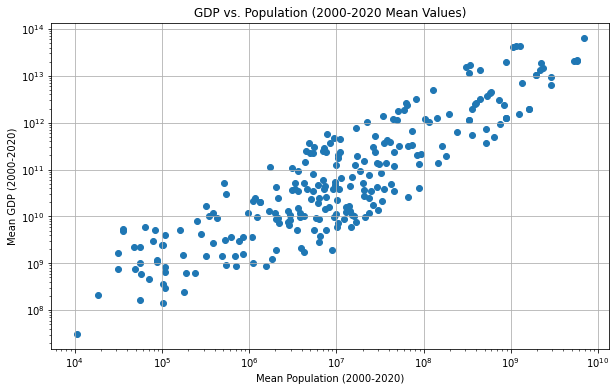

In [9]:
import matplotlib.pyplot as plt

# Merge the two datasets on 'Country Name' to align the GDP and population data
merged_df = pd.merge(gdp_df_filtered[['Country Name', 'Mean GDP 2000-2020']],
                     population_df_filtered[['Country Name', 'Mean Population 2000-2020']],
                     on='Country Name')

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Mean Population 2000-2020'], merged_df['Mean GDP 2000-2020'])

# Adding titles and labels
plt.title('GDP vs. Population (2000-2020 Mean Values)')
plt.xlabel('Mean Population (2000-2020)')
plt.ylabel('Mean GDP (2000-2020)')
plt.xscale('log')  # Using a logarithmic scale for the x-axis can help with wide data ranges
plt.yscale('log')  # Using a logarithmic scale for the y-axis can help with wide data ranges
plt.grid(True)

# Show plot
plt.show()



So I think it would better if I normalise the data before. 

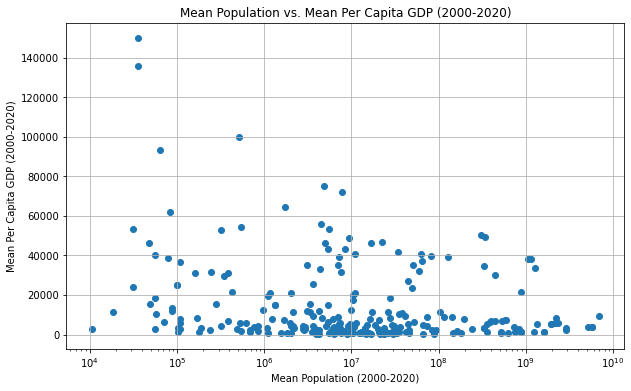

Pearson Correlation Coefficient: -0.09887399904664362


In [10]:
# Calculate the mean per capita GDP for each country
merged_df['Mean Per Capita GDP'] = merged_df['Mean GDP 2000-2020'] / merged_df['Mean Population 2000-2020']

# Visualize the relationship between mean population and mean per capita GDP
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Mean Population 2000-2020'], merged_df['Mean Per Capita GDP'])

# Adding titles and labels
plt.title('Mean Population vs. Mean Per Capita GDP (2000-2020)')
plt.xlabel('Mean Population (2000-2020)')
plt.ylabel('Mean Per Capita GDP (2000-2020)')
plt.xscale('log')  # Using a logarithmic scale for the x-axis
plt.grid(True)

# Show plot
plt.show()

# Compute the Pearson correlation coefficient
correlation_coefficient = merged_df['Mean Population 2000-2020'].corr(merged_df['Mean Per Capita GDP'])
print("Pearson Correlation Coefficient:", correlation_coefficient)


In [13]:
import plotly.express as px

# Assuming merged_df is your DataFrame and it contains a 'Country' column with the country names

# Calculate the mean per capita GDP for each country
merged_df['Mean Per Capita GDP'] = merged_df['Mean GDP 2000-2020'] / merged_df['Mean Population 2000-2020']

# Visualize the relationship between mean population and mean per capita GDP using Plotly
fig = px.scatter(merged_df, x='Mean Population 2000-2020', y='Mean Per Capita GDP', 
                 log_x=True, # Apply logarithmic scale to x-axis
                 hover_name='Country Name', # Show country name on hover
                 title='Mean Population vs. Mean Per Capita GDP (2000-2020)',
                 labels={'Mean Population 2000-2020': 'Mean Population (2000-2020)', 'Mean Per Capita GDP': 'Mean Per Capita GDP (2000-2020)'})

# Show the figure
fig.show()

# Compute the Pearson correlation coefficient
correlation_coefficient = merged_df['Mean Population 2000-2020'].corr(merged_df['Mean Per Capita GDP'])
print("Pearson Correlation Coefficient:", correlation_coefficient)


Pearson Correlation Coefficient: -0.09887399904664362


So it looks like their is not much correlation between the mean population and the mean per capita GDP. Their is a slight negative correlation which suggests a weak negative linear relationship.

In [17]:
from sklearn.linear_model import LinearRegression
import numpy as np
import plotly.graph_objects as go

# Assuming merged_df is your DataFrame

# Prepare the data for linear regression
X = merged_df[['Mean Population 2000-2020']]  # Independent variable (mean population)
y = merged_df['Mean Per Capita GDP']          # Dependent variable (mean per capita GDP)

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Coefficients and intercept
print("Coefficient:", model.coef_[0])
print("Intercept:", model.intercept_)

# Predict y values using the model for a smooth line
X_predict = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)  # Generating values in the range of X for prediction
y_predict = model.predict(X_predict)

# Plotting
fig = go.Figure()

# Add the scatter plot
fig.add_trace(go.Scatter(x=merged_df['Mean Population 2000-2020'], y=merged_df['Mean Per Capita GDP'], mode='markers', name='Data Points', hovertext=merged_df['Country Name']))

# Add the regression line
fig.add_trace(go.Scatter(x=X_predict.flatten(), y=y_predict, mode='lines', name='Regression Line'))

# Correctly apply logarithmic scale to x-axis
fig.update_xaxes(type="log")

# Update the layout
fig.update_layout(title='Mean Population vs. Mean Per Capita GDP with Linear Regression (2000-2020)',
                  xaxis_title='Mean Population (2000-2020)',
                  yaxis_title='Mean Per Capita GDP (2000-2020)')

# Show the figure
fig.show()



Coefficient: -2.4026363144955603e-06
Intercept: 14904.541760017737


c:\Users\Hamid\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\Hamid\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\Hamid\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\Hamid\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\Hamid\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `

The slope coefficient of approximately -2.4026e-06 indicates that for every one-unit increase in the mean population of a country, the mean GDP per capita decreases by approximately 2.4026e-06 units, holding all other variables constant.

The intercept of approximately 14904.54 represents the estimated mean GDP per capita when the mean population is zero. However, this intercept may not have a practical interpretation in this context, as it falls outside the range of reasonable values for mean population.

Overall, the extremely small slope coefficient suggests that changes in population have a negligible impact on mean GDP per capita according to this linear regression model.